# Statistical Process Control (SPC) Algorithm

## Table of contents:

<ol>
    <li>Algorithm</li>
        <ul>
            <li><a href='#overview'>Overview</a></li>
            <li><a href='#code'>Module Implementation</a></li>
        </ul>
    <li>Data TODO</li>
    <li><a href='#demo'>DEMO</a></li>
    <li>Findings and Conclusions
        <ul>
        <li><a href='#model'>Effect of model choices</a></li>
        <li><a href='#fading'>Effect of exponentially smoothing the error</a></li>
        <li><a href='#window'>Effect of sliding window strategy to update the error</a> TODO</li>
        <li>Non linear boundaries to define concepts or change in hidden variables (non predictive features) to define different concepts TODO</li>
        </ul>
    </li>
</ol>

<a id='overview'></a>
## 1 - SPC Overview

#### Theoretical Refresher from Change Detection class (05/3/2024)
_Gama, et. al, Learning with Drift Detection, Lecture Notes in Computer
Science 3171, Springer._

- Suppose a sequence of examples in the form $< \overline{xi}, yi >$
- The current decision model classifies each example in the sequence
- In the 0-1 loss function, predictions are either True or False
- The predictions of the learning algorithm are sequences: $True$,$False$,$True$,$False$,$True$,$False$,$True$,$True$,$True$,$False$,...
- The Error is a random variable from Bernoulli trials
- The Binomial distribution gives the general form of the probability of observing a $False$: $p_i = \frac{{\#F}}{{i}}$ and $s_i = \sqrt{\frac{{p_i(1 - p_i)}}{{i}}}$, where i is the number of trials

The Statistical Process Control algorithm maintains two registers:
- $P_{min}$ and $S_{min}$ such that $P_{min} + S_{min} = min(p_i + s_i)$. The minimum error rate taking into account the variance of the estimator

At example $j$, the error of the learning algorithm will be:
- In-control if $p_j + s_j < P_{min} + 2 ∗ S_{min}$
- Out-control if $p_j + s_j \geq P_{min} + 3 ∗ S_{min}$
- Warning Level if $P_{min} + 3 ∗ S_{min} \geq p_j + s_j > P_{min} + 2 ∗ S_{min}$

![image.png](attachment:image.png)

- At example $j$ the current decision model classifies the example 
- Compute the error and variance: $p_j$ and $s_j$
- If the error is
    - In-control: The current model is updated. Incorporate the example in the decision model
    - Warning: Maintain the current model. First Time: the lower limit of the window is: $L_{warning} = j$
    - Out-Control: Re-learn a new model using as training set the set of examples $[L_{warning} , j]$

<a id='code'></a>
## 2- SPC Module Implementation

The SPC module implements the detector class (SPCAlgorithm). Within this class, the following methods are defined:
- \_\_init__() : class initialization. It requires a function that initializes a river compatible estimator (ML model) to be given by the user.
- _update() : receives the ML model result, calculates the current error rate (p) and variance (s) and updates the Pmin and Smin if needed. Then it checks and returns the process status (In-control, Warning, Out-control).
- _model_train() : trains the ML model with the last iput or with a batch of inputs if re-training is needed.
- _reset_model() : re-initializes the ML model if re-training is needed, by calling the estimator initialization function given by the user..
- model_control() : wrapper function that calls reset_model() and train_model(), depending on the status returned by update(). This function is intended to be called by the user from outside the module.
- process_plot() : generates plots containing the process control results. This function is intended to be called by the user from outside the module.

In [1]:
#from SPC_module.SPC import SPCAlgorithm
from river import compat
from river import metrics
from river import preprocessing
import pandas as pd
import os
import warnings
import numpy as np
import pyformulas as pf
import matplotlib.pyplot as plt
import time
from sklearn import naive_bayes
from sklearn import linear_model
from sklearn import neural_network

warnings.filterwarnings("ignore")

In [2]:
import river
import matplotlib.pyplot as plt


status_dict = {
    "In-control"   : 0,
    "Warning Level": 1,
    "Out-control"  : 2
}

class SPCAlgorithm:
    def __init__(self, init_estimator):
        self.Pmin = 1.0 # initialization
        self.Smin = 0.0 # initialization
        self.num_negative = 0
        self.num_examples = 0
        self.error_rates = [] # for plotting
        self._init_estimator = init_estimator
        self._reset_model()
        self.warn = -1
        self.warning_level = []
        self.drift_level = []
        self.states = []
        self.models = [] # to plot decision boundaries
        self.ps = [] # debug
        self.ss = [] # debug
        self.Pmins = [] # debug
        self.Smins = [] # debug

    def update(self, y):
        # Update counts
        self.num_examples += 1
        if (y == False):
            self.num_negative += 1
        # Calculate p and s
        p = self.num_negative / self.num_examples
        s = (p * (1 - p) / self.num_examples) ** 0.5

        # Check process status
        if p + s >= self.Pmin + 3 * self.Smin:
            status = "Out-control"
        elif p + s >= self.Pmin + 2 * self.Smin:
            status = "Warning Level"
        else:
            status = "In-control"
            self.warn = -1 # false alarm error keeps decreasing
                
        self.warning_level.append(self.Pmin + 2 * self.Smin)        
        self.drift_level.append(self.Pmin + 3 * self.Smin)
        self.Pmins.append(self.Pmin)
        self.Smins.append(self.Smin)

        # Update Pmin and Smin
        if p+s != 0.0 and p + s < self.Pmin + self.Smin:
            self.Pmin = min(p, self.Pmin) # p
            self.Smin = (self.Pmin * (1 - self.Pmin) / self.num_examples) ** 0.5 # s
            self.warn = -1 # false alarm error keeps decreasing

        return status, p, s

    def _exponential_smoothing_update(self, y, alpha=0.9):
        # Update counts
        self.num_examples += 1
        
        # Calculate p and s
        #try:
        #    p = self.ps[-1]*((self.num_examples-1)/self.num_examples)*alpha + (1-alpha)*((y == False)+0) / self.num_examples
        #except:
            # first iteration
        #    p = ((y == False)+0) / self.num_examples
        p = (alpha*self.num_negative + (y == False)+0)/self.num_examples
        s = (p * (1 - p) / self.num_examples) ** 0.5
        self.num_negative += (y == False)+0
        
        # Check process status
        if p + s >= self.Pmin + 3 * self.Smin:
            status = "Out-control"
        elif p + s >= self.Pmin + 2 * self.Smin:
            status = "Warning Level"
        else:
            status = "In-control"
            self.warn = -1 # false alarm error keeps decreasing
                
        self.warning_level.append(self.Pmin + 2 * self.Smin)        
        self.drift_level.append(self.Pmin + 3 * self.Smin)
        self.Pmins.append(self.Pmin)
        self.Smins.append(self.Smin)

        # Update Pmin and Smin
        if p+s != 0.0 and p + s < self.Pmin + self.Smin:
            self.Pmin = min(p, self.Pmin) # p
            self.Smin = (self.Pmin * (1 - self.Pmin) / self.num_examples) ** 0.5 # s
            self.warn = -1 # false alarm error keeps decreasing
        
        return status, p, s
        

    def _model_train(self, data):
        if len(data.shape) > 1:
            # batch learning
            self.model.learn_many(data.iloc[:, :-1], data.iloc[:, -1])
        else:
            # single sample fitting
            self.model.learn_one(data[:-1], data[-1])
    
    def _reset_model(self):
        try:
            self.models.append(self.model)
        except:
            self.models = [] # first call
        self.model = self._init_estimator()


    def model_control(self, data, sample_id, exponential=False):
        x = data.iloc[sample_id, :-1]
        y = data.iloc[sample_id, -1]
        y_pred = self.model.predict_one(x)

        if exponential: 
            status, p, s = self._exponential_smoothing_update(y_pred==y)
        else:
            status, p, s = self.update(y_pred==y)
            
        to_return = [status, y, y_pred]
        self.error_rates.append(p+s)
        self.ps.append(p)
        self.ss.append(s)
        
        # check detector status
        if status == 'Warning Level' and self.warn == -1:
            self.warn = sample_id
            
        elif status == 'Out-control':
            self._reset_model()
            if self.warn == -1: self.warn = sample_id
            self._model_train(data.iloc[self.warn:sample_id+1,:])

            n, e = 0, 0
            for i in range(self.warn,sample_id+1):
                x = data.iloc[i, :-1]
                y = data.iloc[i, -1]
                y_pred = self.model.predict_one(x)
                n += 1
                e += (y!=y_pred)+0
            print('Num examples post retraining = ', n)
            print('Num negatives post retraining = ', e)
            p = e/n
            s = (p * (1 - p) / n) ** 0.5
            self.ps[-1] = p
            self.ss[-1] = s
            self.num_examples = n
            self.num_negative = e
            self.Pmin = p
            self.Smin = s
            self.Pmins[-1] = p
            self.Smins[-1] = s
            self.warn = -1
            
        else:
            self._model_train(data.iloc[sample_id,:])
        
        self.states.append(status_dict[status])
        return to_return

    def process_plot(self):
        # Plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        # Plot
        ax1.plot(range(1, len(self.error_rates) + 1), self.error_rates, marker='o', markersize=1, label='Error Rate')
        ax1.plot(range(1, len(self.warning_level) + 1), self.warning_level, color='r', linestyle='--', label='Warning Level')
        ax1.plot(range(1, len(self.drift_level) + 1), self.drift_level, color='g', linestyle='--', label='Drift Level')
        ax1.set_xlabel('Number of processed samples')
        ax1.set_ylabel('Error rate')
        ax1.set_title('Error Rate Across Processed Samples with SPC Indicators')
        ax1.grid(True)
        ax1.set_ylim(0.0, max(self.error_rates[100:]))
        ax1.legend()
        # Plotting states
        ax2.plot(range(1, len(self.states) + 1), self.states, marker='o', linestyle='-', color='b')
        ax2.set_xlabel('Number of processed samples')
        ax2.set_ylabel('State')
        ax2.set_title('State Across Processed Samples')
        ax2.set_yticks([0, 1, 2])
        ax2.set_yticklabels(['Normal', 'Warning', 'Out of Control'])
        ax2.grid(True)
        plt.tight_layout()
        plt.show()

In [3]:
def live_error(error, ranges, drifts, size=100, screen=None, fig=None):
    if screen == None:
        screen = pf.screen(title='Error Evolution')
        fig = plt.figure()
        
    if len(error) > size:
        error = error[-size:] # plot the most recent error
        ranges = ranges[-size:]

    plt.clf()
    plt.title('Error evolution')
    plt.grid(True)
    plt.ylabel('Error')
    plt.xlabel('Examples')
    plt.xlim(ranges[0], ranges[-1])
    plt.ylim(min(error)-0.001, max(error)+0.001)
    plt.plot(ranges, error, color='black', marker='.', linestyle='--')
    
    real = 15000*np.arange(1, 8) # real drifts
    plt.vlines(x=[d-1 for d in real if d-1 >= ranges[0] and d-1 <= ranges [-1]],
               ymin=min(error)-0.001, ymax=max(error)+0.001, label='Real Drift',
               linestyle='--', color='blue')
    plt.vlines(x=[d-1 for d in drifts if d-1 >= ranges[0] and d-1 <= ranges [-1]],
                   ymin=min(error)-0.001, ymax=max(error)+0.001, label='Detected Drift',
                   linestyle='--', color='red')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.21), ncols=2)
    
    #if [d-1 for d in real if d-1 >= ranges[0] and d-1 <= ranges [-1]] != []:
    #    for point in [(d-1, error[d%500]) for d in real if d-1 >= ranges[0] and d-1 <= ranges [-1]]:
    #        plt.annotate('Real Drift', xy=point, xycoords='axes points', color='blue')
        
    #if [d-1 for d in drifts if d-1 >= ranges[0] and d-1 <= ranges [-1]] != []:
    #    for point in [(d-1, error[d-1]) for d in drifts if d-1 >= ranges[0] and d-1 <= ranges [-1]]:
    #        plt.annotate('Detected Drift', xy=point, xycoords='axes points', color='red')
    plt.tight_layout()
    
    # Draw the figure
    fig.canvas.draw()

    # Convert the figure to an image
    image = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    screen.update(image)
    
    return screen, fig

In [4]:
PATH = os.path.dirname(os.path.abspath('__file__'))
data_stream = pd.read_csv(f"{PATH}/data/SEAconcepts.csv")

In [5]:
def init_estimator_GaussianNB():
    #model = preprocessing.StandardScaler()
    model = compat.convert_sklearn_to_river(
        estimator=naive_bayes.GaussianNB(),
        classes=[False, True]
    )
    return model

<a id='demo'></a>
## DEMO:

Error after 500 samples = 17.0%
Error after 1000 samples = 14.5%
Error after 1500 samples = 13.6%
Error after 2000 samples = 13.55%
Error after 2500 samples = 13.12%
Error after 3000 samples = 13.27%
Error after 3500 samples = 12.77%
Error after 4000 samples = 12.52%
Error after 4500 samples = 12.73%
Error after 5000 samples = 12.74%
Error after 5500 samples = 12.76%
Error after 6000 samples = 12.72%
Error after 6500 samples = 12.49%
Error after 7000 samples = 12.39%
Error after 7500 samples = 12.36%
Error after 8000 samples = 12.32%
Error after 8500 samples = 12.35%
Error after 9000 samples = 12.39%
Error after 9500 samples = 12.38%
Error after 10000 samples = 12.36%
Error after 10500 samples = 12.45%
Error after 11000 samples = 12.56%
Error after 11500 samples = 12.5%
Error after 12000 samples = 12.51%
Error after 12500 samples = 12.46%
Error after 13000 samples = 12.45%
Error after 13500 samples = 12.37%
Error after 14000 samples = 12.24%
Error after 14500 samples = 12.2%
Error afte

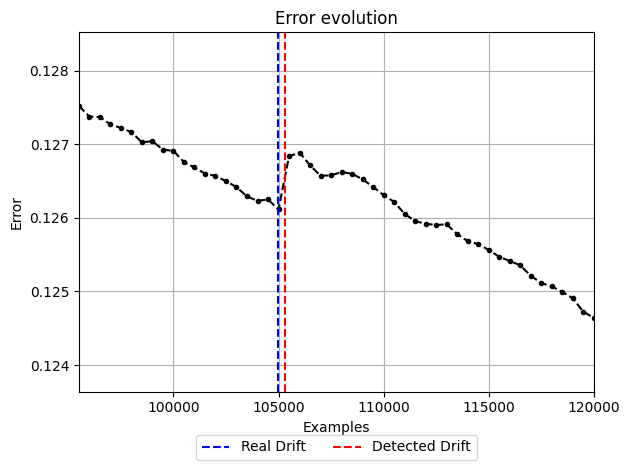

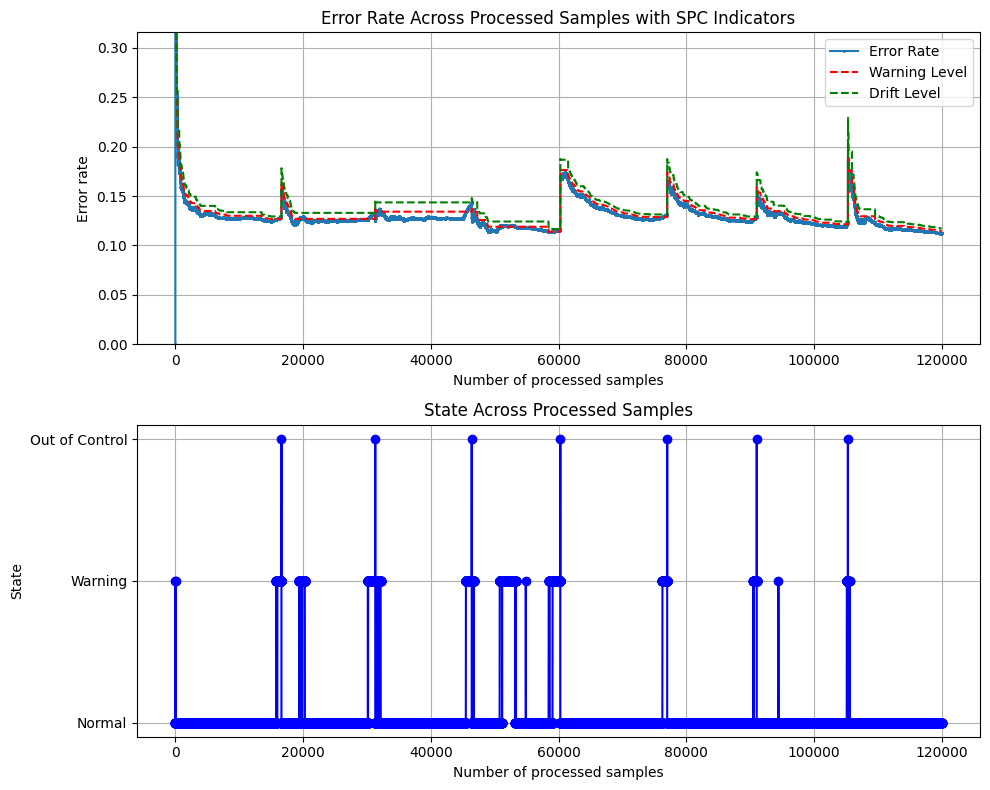

In [6]:
spc_detector = SPCAlgorithm(init_estimator_GaussianNB)
#metric = metrics.Accuracy()

report = 500
warn = -1
retrain = -1
E, N, screen, fig = [0], [0], None, None
drifts = []

for i in range(data_stream.shape[0]):
    status, y, y_pred = spc_detector.model_control(data_stream, i)
    N.append(N[-1] + 1)
    E.append(E[-1] + (y!=y_pred)+0)
    #metric.update(y, y_pred)

    if status == 'Out-control': drifts.append(i)

    if (i+1)%report == 0: 
        #print(f'{i+1} samples:', metric)
        print(f'Error after {i+1} samples = {np.round(100*E[-1]/N[-1], 2)}%')
        E, N = np.array(E), np.array(N)
        #print(E[np.arange(report, i+2, report)])
        #print(N[np.arange(report, i+2, report)])
        screen, fig = live_error(E[np.arange(report, i+2, report)]/N[np.arange(report, i+2, report)],
                                 N[np.arange(report, i+2, report)], drifts=drifts, size=50, screen=screen, fig=fig)
        E, N = list(E), list(N)

    if status == 'Warning Level' and warn == -1 and i!=0:
        warn = i
        retrain = -1
        #print(f'Warning after {i+1} samples')
    elif status == 'Out-control' and retrain == -1 and i!=0:
        #print(f'Re-train model after {i+1} samples')
        retrain = i
        warn = -1
    else:
        warn = -1
        retrain = -1


#print(f'{i+1} samples:', metric)

# Plotting
time.sleep(2)
screen.close()
spc_detector.process_plot()

In [7]:
[i for i in range(len(spc_detector.states)) if spc_detector.states[i] == 2]

[16614, 31303, 46405, 60283, 77016, 91039, 105313]

In [9]:
# IMP - juntar ao outro ciclo para fazer ao mesmo tempo!
baseline, e = [], 0
model = init_estimator_GaussianNB()

for i in range(data_stream.shape[0]):
    y_pred = model.predict_one(data_stream.iloc[i, :-1])
    model.learn_one(data_stream.iloc[i, :-1], data_stream.iloc[i, -1])
    e += (data_stream.iloc[i, -1] != y_pred)+0
    baseline.append(e/(i+1))

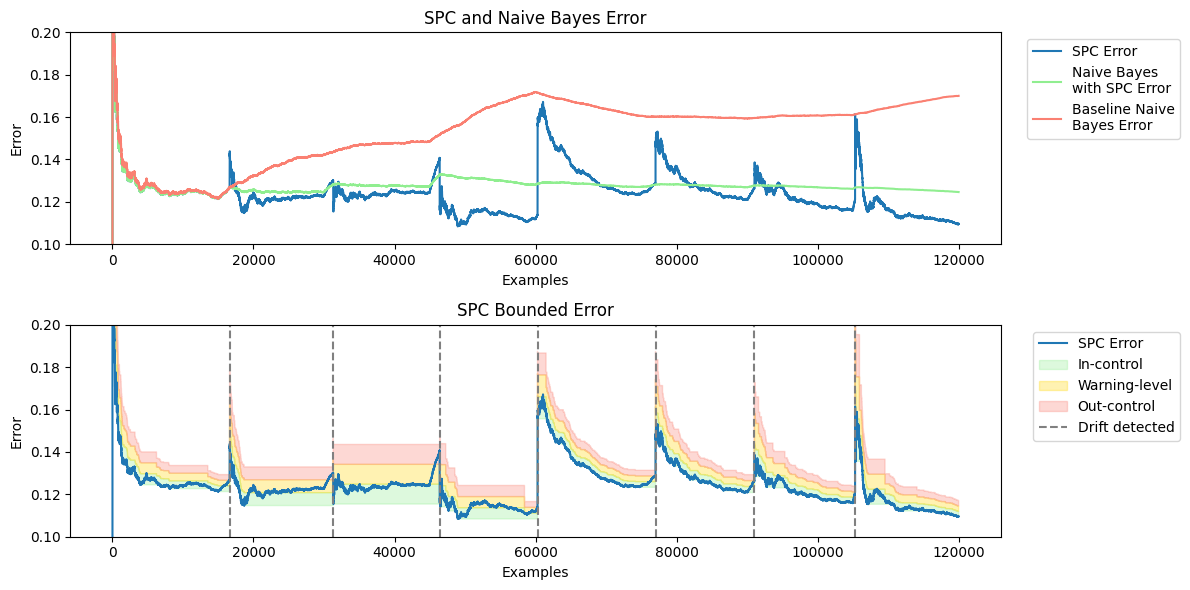

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
ax1.plot(N[1:], np.array(spc_detector.ps), label='SPC Error')
ax1.plot(N[1:], np.array(E[1:])/np.array(N[1:]), color='lightgreen', label='Naive Bayes\nwith SPC Error')
ax1.plot(N[1:], baseline, color='salmon', label='Baseline Naive\nBayes Error')

ax2.plot(N[1:], np.array(spc_detector.ps), label='SPC Error')
ax2.fill_between(N[1:], np.array(spc_detector.Pmins), np.array(spc_detector.Pmins) + np.array(spc_detector.Smins),
                 alpha=0.3, color='lightgreen', label='In-control')
ax2.fill_between(N[1:], np.array(spc_detector.Pmins) + np.array(spc_detector.Smins),
                        np.array(spc_detector.Pmins) + 2*np.array(spc_detector.Smins), alpha=0.3, color='gold', label='Warning-level')
ax2.fill_between(N[1:], np.array(spc_detector.Pmins) + 2*np.array(spc_detector.Smins),
                        np.array(spc_detector.Pmins) + 3*np.array(spc_detector.Smins), alpha=0.3, color='salmon', label='Out-control')
ax2.vlines([i for i in range(len(spc_detector.states)) if spc_detector.states[i] == 2], ymin=0.1, ymax=0.2,
           color='grey', linestyles='dashed', label='Drift detected')

ax1.set_ylim(0.1, 0.2)
ax2.set_ylim(0.1, 0.2)
ax1.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
ax2.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
ax1.set_title('SPC and Naive Bayes Error')
ax2.set_title('SPC Bounded Error')
ax1.set_xlabel('Examples')
ax2.set_xlabel('Examples')
ax1.set_ylabel('Error')
ax2.set_ylabel('Error')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Time difference between real and detected drift (avg = 1139)')

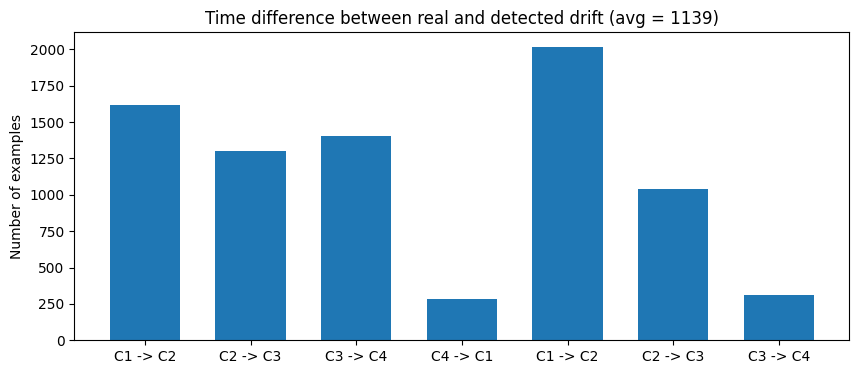

In [11]:
detected = np.array([i for i in range(len(spc_detector.states)) if spc_detector.states[i] == 2])
real = 15000*np.array(np.arange(1,8))

fig = plt.figure(figsize=(10,4))
plt.bar([0.3, 0.75, 1.2, 1.65, 2.1, 2.55, 3.0], detected-real, width=0.3)
plt.xticks(ticks=[0.3, 0.75, 1.2, 1.65, 2.1, 2.55, 3.0],
           labels=['C1 -> C2', 'C2 -> C3', 'C3 -> C4', 'C4 -> C1', 'C1 -> C2', 'C2 -> C3', 'C3 -> C4'])

plt.ylabel('Number of examples')
plt.title(f'Time difference between real and detected drift (avg = {int(np.mean(detected-real))})')

## 4 - Findings and Conclusions

<a id='model'></a>
### 4.1 - Effect of model choices:

#### 4.1.1 - Naive Bayes with standard scaling:

In [119]:
def init_estimator_StandardizedGaussianNB():
    model = preprocessing.StandardScaler()
    model |= compat.convert_sklearn_to_river(
        estimator=naive_bayes.GaussianNB(),
        classes=[False, True]
    )
    return model

In [ ]:
baseline, e = [], 0
model = init_estimator_GaussianNB()

for i in range(data_stream.shape[0]):
    y_pred = model.predict_one(data_stream.iloc[i, :-1])
    model.learn_one(data_stream.iloc[i, :-1], data_stream.iloc[i, -1])
    e += (data_stream.iloc[i, -1] != y_pred)+0
    baseline.append(e/(i+1))

Error after 500 samples = 18.4%
Error after 1000 samples = 15.2%
Error after 1500 samples = 14.13%
Error after 2000 samples = 13.85%
Error after 2500 samples = 13.28%
Error after 3000 samples = 13.37%
Error after 3500 samples = 12.8%
Error after 4000 samples = 12.55%
Error after 4500 samples = 12.73%
Error after 5000 samples = 12.76%
Error after 5500 samples = 12.8%
Error after 6000 samples = 12.77%
Error after 6500 samples = 12.51%
Error after 7000 samples = 12.4%
Error after 7500 samples = 12.37%
Error after 8000 samples = 12.3%
Error after 8500 samples = 12.33%
Error after 9000 samples = 12.36%
Error after 9500 samples = 12.35%
Error after 10000 samples = 12.33%
Error after 10500 samples = 12.43%
Error after 11000 samples = 12.55%
Error after 11500 samples = 12.49%
Error after 12000 samples = 12.48%
Error after 12500 samples = 12.42%
Error after 13000 samples = 12.42%
Error after 13500 samples = 12.34%
Error after 14000 samples = 12.21%
Error after 14500 samples = 12.17%
Error after

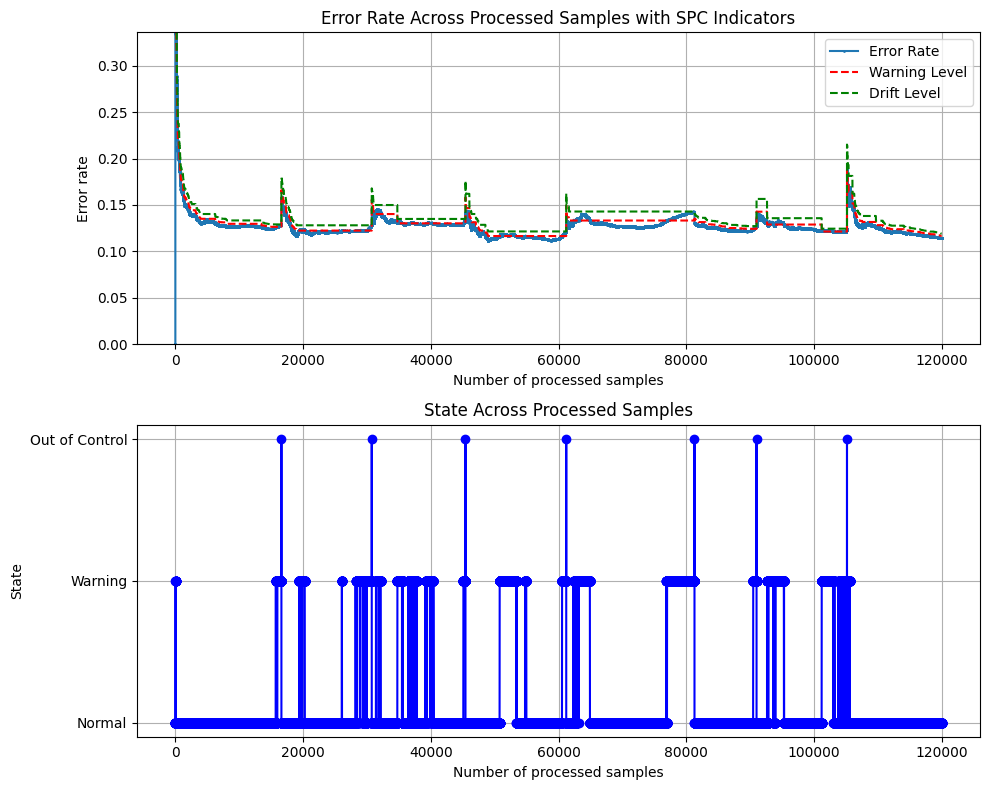

In [125]:
spc_detector = SPCAlgorithm(init_estimator_StandardizedGaussianNB)

report = 500
warn = -1
retrain = -1
E, N = [0], [0]
baseline, e = [], 0
baseline_model = init_estimator_StandardizedGaussianNB()

for i in range(data_stream.shape[0]):
    status, y, y_pred = spc_detector.model_control(data_stream, i)
    N.append(N[-1] + 1)
    E.append(E[-1] + (y!=y_pred)+0)

    # baseline
    y_pred = baseline_model.predict_one(data_stream.iloc[i, :-1])
    baseline_model.learn_one(data_stream.iloc[i, :-1], data_stream.iloc[i, -1])
    e += (data_stream.iloc[i, -1] != y_pred)+0
    baseline.append(e/(i+1))

    if (i+1)%report == 0: 
        print(f'Error after {i+1} samples = {np.round(100*E[-1]/N[-1], 2)}%')
        E, N = np.array(E), np.array(N)
        E, N = list(E), list(N)

    if status == 'Warning Level' and warn == -1 and i!=0:
        warn = i
        retrain = -1
        #print(f'Warning after {i+1} samples')
    elif status == 'Out-control' and retrain == -1 and i!=0:
        print(f'Re-train model after {i+1} samples')
        retrain = i
        warn = -1
    else:
        warn = -1
        retrain = -1

# Plotting
spc_detector.process_plot()

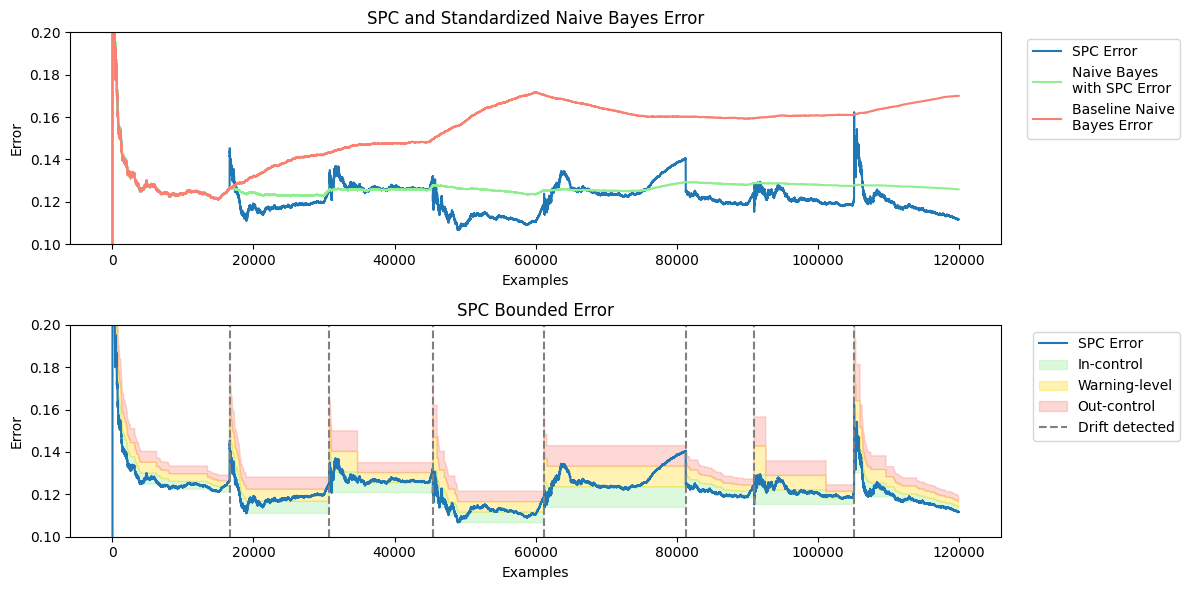

In [126]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
ax1.plot(N[1:], np.array(spc_detector.ps), label='SPC Error')
ax1.plot(N[1:], np.array(E[1:])/np.array(N[1:]), color='lightgreen', label='Naive Bayes\nwith SPC Error')
ax1.plot(N[1:], baseline, color='salmon', label='Baseline Naive\nBayes Error')

ax2.plot(N[1:], np.array(spc_detector.ps), label='SPC Error')
ax2.fill_between(N[1:], np.array(spc_detector.Pmins), np.array(spc_detector.Pmins) + np.array(spc_detector.Smins),
                 alpha=0.3, color='lightgreen', label='In-control')
ax2.fill_between(N[1:], np.array(spc_detector.Pmins) + np.array(spc_detector.Smins),
                        np.array(spc_detector.Pmins) + 2*np.array(spc_detector.Smins), alpha=0.3, color='gold', label='Warning-level')
ax2.fill_between(N[1:], np.array(spc_detector.Pmins) + 2*np.array(spc_detector.Smins),
                        np.array(spc_detector.Pmins) + 3*np.array(spc_detector.Smins), alpha=0.3, color='salmon', label='Out-control')
ax2.vlines([i for i in range(len(spc_detector.states)) if spc_detector.states[i] == 2], ymin=0.1, ymax=0.2,
           color='grey', linestyles='dashed', label='Drift detected')

ax1.set_ylim(0.1, 0.2)
ax2.set_ylim(0.1, 0.2)
ax1.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
ax2.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
ax1.set_title('SPC and Standardized Naive Bayes Error')
ax2.set_title('SPC Bounded Error')
ax1.set_xlabel('Examples')
ax2.set_xlabel('Examples')
ax1.set_ylabel('Error')
ax2.set_ylabel('Error')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Time difference between real and detected drift (avg = 1639)')

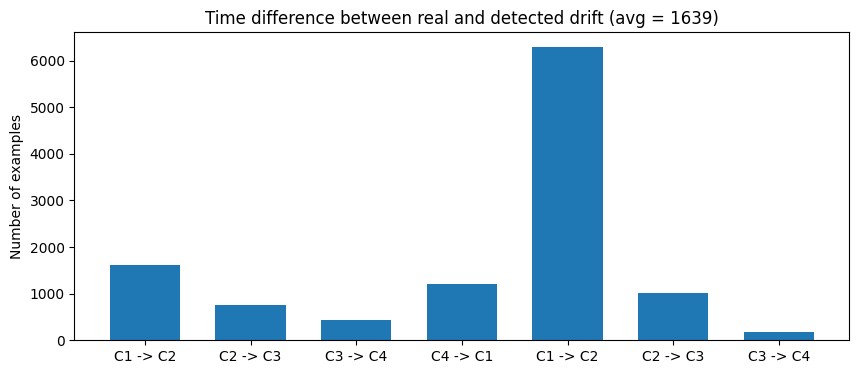

In [127]:
detected = np.array([i for i in range(len(spc_detector.states)) if spc_detector.states[i] == 2])
real = 15000*np.array(np.arange(1,8))

fig = plt.figure(figsize=(10,4))
plt.bar([0.3, 0.75, 1.2, 1.65, 2.1, 2.55, 3.0], detected-real, width=0.3)
plt.xticks(ticks=[0.3, 0.75, 1.2, 1.65, 2.1, 2.55, 3.0],
           labels=['C1 -> C2', 'C2 -> C3', 'C3 -> C4', 'C4 -> C1', 'C1 -> C2', 'C2 -> C3', 'C3 -> C4'])

plt.ylabel('Number of examples')
plt.title(f'Time difference between real and detected drift (avg = {int(np.mean(detected-real))})')

#### 4.1.2 - SGD Classifier:

In [128]:
def init_estimator_SGDClassifier():
    model = preprocessing.StandardScaler()
    model |= compat.convert_sklearn_to_river(
    estimator=linear_model.SGDClassifier(
        loss='log_loss',                   # 'log_loss' gives LOGISTIC REGRESSION. Uncomment to use it.
        #loss='hinge',                     # 'hinge' gives a LINEAR SVM. Uncomment to use it.
        #loss='perceptron',                # 'perceptron' is the linear loss used by the PERCEPTRON algorithm. Uncomment to use it.
        #loss='modified_huber',            # 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates. Uncomment to use it.
        #loss='squared_hinge',             # 'squared_hinge' is like hinge but is quadratically penalized. Uncomment to use it.
        eta0=0.001,
        learning_rate='constant',
        random_state=42
    ),
    classes=[False, True]
    )
    return model

Error after 500 samples = 17.8%
Error after 1000 samples = 15.1%
Error after 1500 samples = 14.27%
Error after 2000 samples = 14.1%
Error after 2500 samples = 13.6%
Error after 3000 samples = 13.37%
Error after 3500 samples = 12.83%
Error after 4000 samples = 12.48%
Error after 4500 samples = 12.67%
Error after 5000 samples = 12.66%
Error after 5500 samples = 12.58%
Error after 6000 samples = 12.32%
Error after 6500 samples = 12.03%
Error after 7000 samples = 11.9%
Error after 7500 samples = 11.8%
Error after 8000 samples = 11.71%
Error after 8500 samples = 11.72%
Error after 9000 samples = 11.7%
Error after 9500 samples = 11.63%
Error after 10000 samples = 11.58%
Error after 10500 samples = 11.65%
Error after 11000 samples = 11.75%
Error after 11500 samples = 11.7%
Error after 12000 samples = 11.66%
Error after 12500 samples = 11.6%
Error after 13000 samples = 11.56%
Error after 13500 samples = 11.47%
Error after 14000 samples = 11.34%
Error after 14500 samples = 11.32%
Error after 15

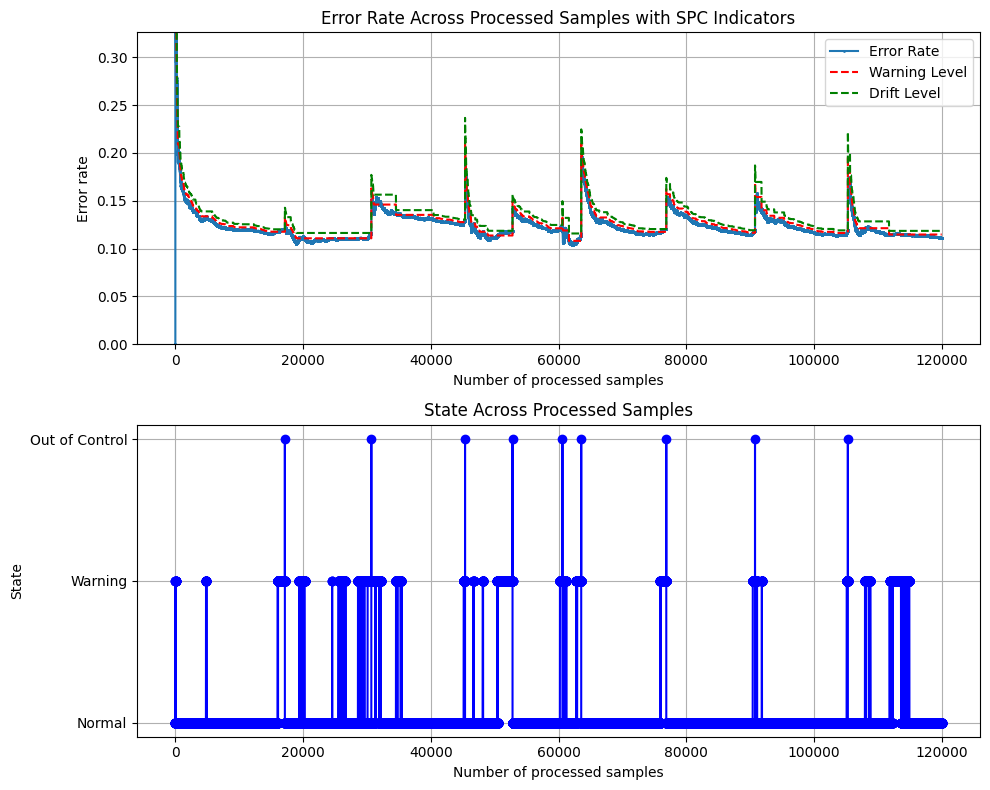

In [129]:
spc_detector = SPCAlgorithm(init_estimator_SGDClassifier)

report = 500
warn = -1
retrain = -1
E, N = [0], [0]
baseline, e = [], 0
baseline_model = init_estimator_SGDClassifier()

for i in range(data_stream.shape[0]):
    status, y, y_pred = spc_detector.model_control(data_stream, i)
    N.append(N[-1] + 1)
    E.append(E[-1] + (y!=y_pred)+0)

    # baseline
    y_pred = baseline_model.predict_one(data_stream.iloc[i, :-1])
    baseline_model.learn_one(data_stream.iloc[i, :-1], data_stream.iloc[i, -1])
    e += (data_stream.iloc[i, -1] != y_pred)+0
    baseline.append(e/(i+1))

    if (i+1)%report == 0: 
        print(f'Error after {i+1} samples = {np.round(100*E[-1]/N[-1], 2)}%')
        E, N = np.array(E), np.array(N)
        E, N = list(E), list(N)

    if status == 'Warning Level' and warn == -1 and i!=0:
        warn = i
        retrain = -1
        #print(f'Warning after {i+1} samples')
    elif status == 'Out-control' and retrain == -1 and i!=0:
        print(f'Re-train model after {i+1} samples')
        retrain = i
        warn = -1
    else:
        warn = -1
        retrain = -1

# Plotting
spc_detector.process_plot()

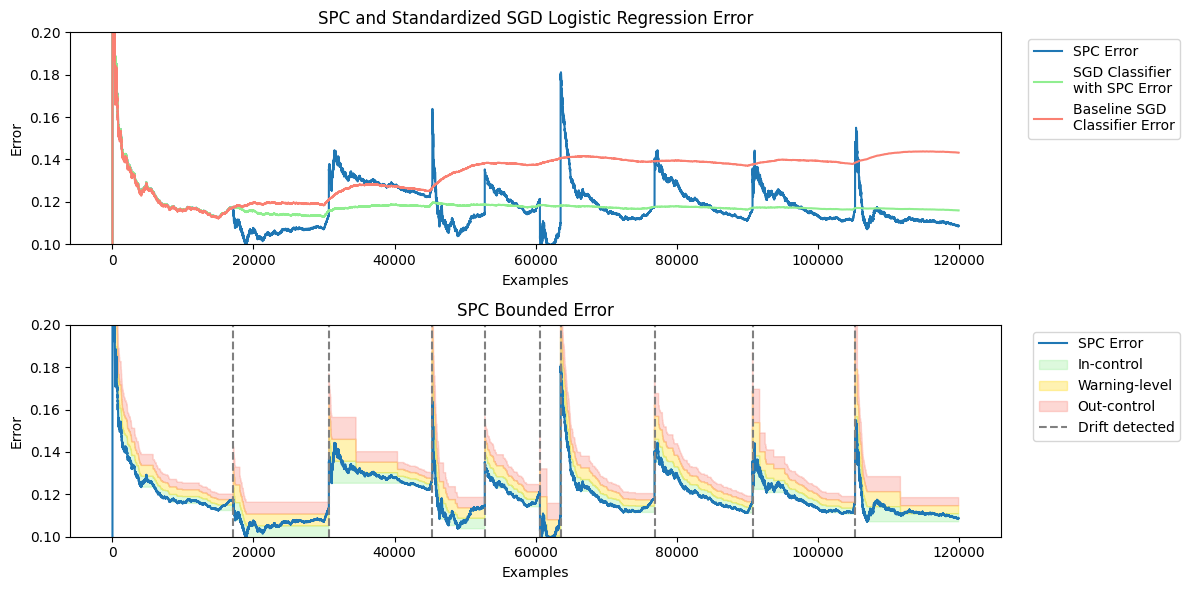

In [130]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
ax1.plot(N[1:], np.array(spc_detector.ps), label='SPC Error')
ax1.plot(N[1:], np.array(E[1:])/np.array(N[1:]), color='lightgreen', label='SGD Classifier\nwith SPC Error')
ax1.plot(N[1:], baseline, color='salmon', label='Baseline SGD\nClassifier Error')

ax2.plot(N[1:], np.array(spc_detector.ps), label='SPC Error')
ax2.fill_between(N[1:], np.array(spc_detector.Pmins), np.array(spc_detector.Pmins) + np.array(spc_detector.Smins),
                 alpha=0.3, color='lightgreen', label='In-control')
ax2.fill_between(N[1:], np.array(spc_detector.Pmins) + np.array(spc_detector.Smins),
                        np.array(spc_detector.Pmins) + 2*np.array(spc_detector.Smins), alpha=0.3, color='gold', label='Warning-level')
ax2.fill_between(N[1:], np.array(spc_detector.Pmins) + 2*np.array(spc_detector.Smins),
                        np.array(spc_detector.Pmins) + 3*np.array(spc_detector.Smins), alpha=0.3, color='salmon', label='Out-control')
ax2.vlines([i for i in range(len(spc_detector.states)) if spc_detector.states[i] == 2], ymin=0.1, ymax=0.2,
           color='grey', linestyles='dashed', label='Drift detected')

ax1.set_ylim(0.1, 0.2)
ax2.set_ylim(0.1, 0.2)
ax1.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
ax2.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
ax1.set_title('SPC and Standardized SGD Logistic Regression Error')
ax2.set_title('SPC Bounded Error')
ax1.set_xlabel('Examples')
ax2.set_xlabel('Examples')
ax1.set_ylabel('Error')
ax2.set_ylabel('Error')
plt.tight_layout()
plt.show()

In [137]:
np.array([i for i in range(len(spc_detector.states)) if spc_detector.states[i] == 2]) # 2 false alarms

array([ 17150,  30688,  45363,  52799,  60614,  63554,  76875,  90769,
       105308])

Text(0.5, 1.0, 'Time difference between real and detected drift (avg = 966)')

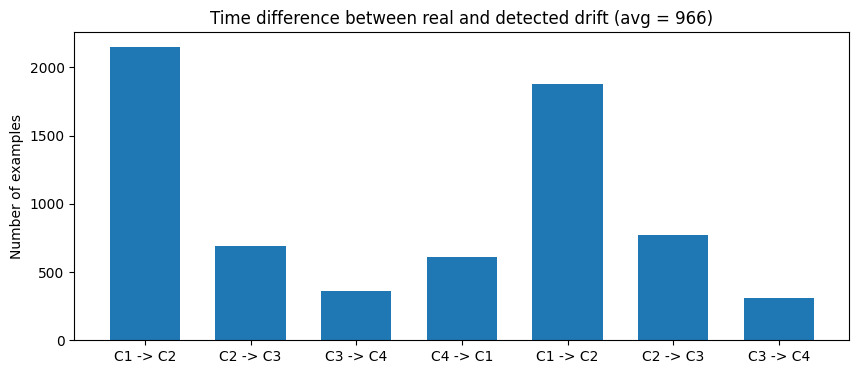

In [138]:
detected = [17150,  30688,  45363,  60614,  76875,  90769, 105308]
real = 15000*np.array(np.arange(1,8))

fig = plt.figure(figsize=(10,4))
plt.bar([0.3, 0.75, 1.2, 1.65, 2.1, 2.55, 3.0], detected-real, width=0.3)
plt.xticks(ticks=[0.3, 0.75, 1.2, 1.65, 2.1, 2.55, 3.0],
           labels=['C1 -> C2', 'C2 -> C3', 'C3 -> C4', 'C4 -> C1', 'C1 -> C2', 'C2 -> C3', 'C3 -> C4'])

plt.ylabel('Number of examples')
plt.title(f'Time difference between real and detected drift (avg = {int(np.mean(detected-real))})')

#### 4.1.3 - MLP Classifier:

In [219]:
def init_estimator_MLP():
    #model = preprocessing.StandardScaler()
    model = compat.convert_sklearn_to_river(
        estimator=neural_network.MLPClassifier(
            hidden_layer_sizes=(12),
            activation='identity',
            solver='adam',
            learning_rate_init=0.005,
            alpha=0.001, # Strength of the L2 regularization term (divided by sample size)
            max_iter=1,
            random_state=42
        ),
        classes=[False, True]
    )
    return model

In [220]:
spc_detector = SPCAlgorithm(init_estimator_MLP)

report = 500
warn = -1
retrain = -1
E, N = [0], [0]
baseline, e = [], 0
baseline_model = init_estimator_MLP()

for i in range(data_stream.shape[0]):
    status, y, y_pred = spc_detector.model_control(data_stream, i)
    N.append(N[-1] + 1)
    E.append(E[-1] + (y!=y_pred)+0)

    # baseline
    y_pred = baseline_model.predict_one(data_stream.iloc[i, :-1])
    baseline_model.learn_one(data_stream.iloc[i, :-1], data_stream.iloc[i, -1])
    e += (data_stream.iloc[i, -1] != y_pred)+0
    baseline.append(e/(i+1))

    if (i+1)%report == 0: 
        print(f'Error after {i+1} samples = {np.round(100*E[-1]/N[-1], 2)}%')
        E, N = np.array(E), np.array(N)
        E, N = list(E), list(N)

    if status == 'Warning Level' and warn == -1 and i!=0:
        warn = i
        retrain = -1
        #print(f'Warning after {i+1} samples')
    elif status == 'Out-control' and retrain == -1 and i!=0:
        print(f'Re-train model after {i+1} samples')
        retrain = i
        warn = -1
    else:
        warn = -1
        retrain = -1

# Plotting
spc_detector.process_plot()

Num examples post retraining =  6
Num negatives post retraining =  4
Re-train model after 16 samples
Error after 500 samples = 31.4%
Error after 1000 samples = 28.0%
Error after 1500 samples = 25.33%
Error after 2000 samples = 23.9%
Error after 2500 samples = 22.48%
Error after 3000 samples = 21.57%
Error after 3500 samples = 20.51%
Error after 4000 samples = 20.0%
Error after 4500 samples = 20.09%
Error after 5000 samples = 19.64%
Error after 5500 samples = 19.53%
Error after 6000 samples = 19.28%
Error after 6500 samples = 18.86%
Error after 7000 samples = 18.57%
Error after 7500 samples = 18.28%
Error after 8000 samples = 18.01%
Error after 8500 samples = 17.84%
Error after 9000 samples = 17.83%
Error after 9500 samples = 17.8%
Error after 10000 samples = 17.59%
Error after 10500 samples = 17.5%
Error after 11000 samples = 17.47%
Error after 11500 samples = 17.38%
Error after 12000 samples = 17.32%
Error after 12500 samples = 17.17%
Error after 13000 samples = 17.08%
Error after 135

KeyboardInterrupt: 

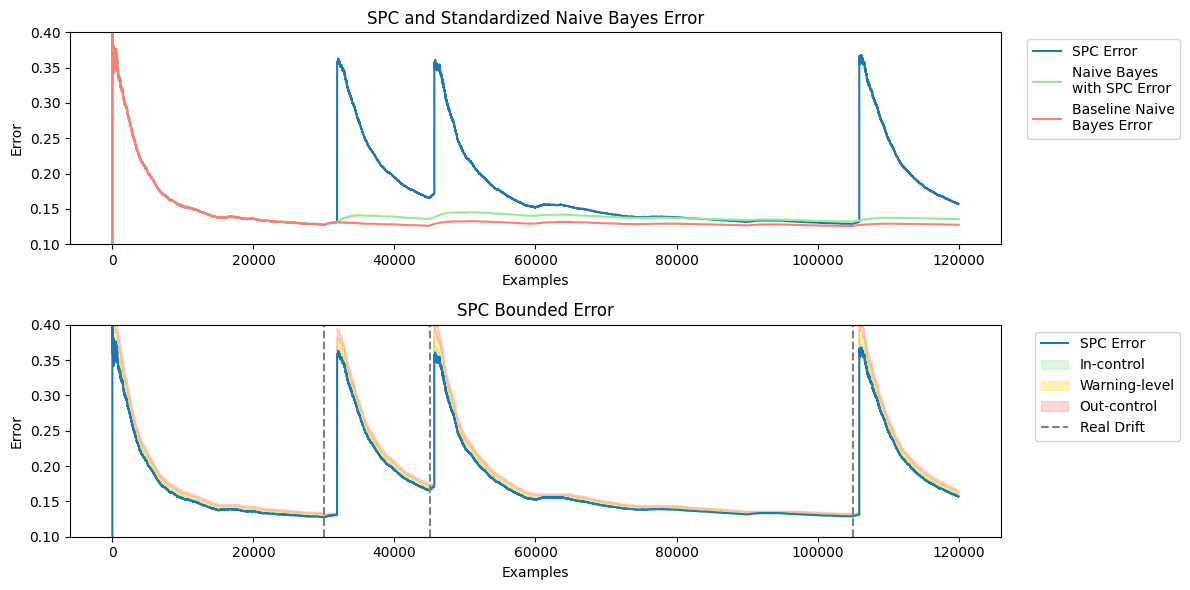

In [155]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
ax1.plot(N[1:], np.array(spc_detector.ps), label='SPC Error')
ax1.plot(N[1:], np.array(E[1:])/np.array(N[1:]), color='lightgreen', label='Naive Bayes\nwith SPC Error')
ax1.plot(N[1:], baseline, color='salmon', label='Baseline Naive\nBayes Error')

ax2.plot(N[1:], np.array(spc_detector.ps), label='SPC Error')
ax2.fill_between(N[1:], np.array(spc_detector.Pmins), np.array(spc_detector.Pmins) + np.array(spc_detector.Smins),
                 alpha=0.3, color='lightgreen', label='In-control')
ax2.fill_between(N[1:], np.array(spc_detector.Pmins) + np.array(spc_detector.Smins),
                        np.array(spc_detector.Pmins) + 2*np.array(spc_detector.Smins), alpha=0.3, color='gold', label='Warning-level')
ax2.fill_between(N[1:], np.array(spc_detector.Pmins) + 2*np.array(spc_detector.Smins),
                        np.array(spc_detector.Pmins) + 3*np.array(spc_detector.Smins), alpha=0.3, color='salmon', label='Out-control')
#ax2.vlines([i for i in range(len(spc_detector.states)) if spc_detector.states[i] == 2], ymin=0.1, ymax=0.4,
#           color='grey', linestyles='dashed', label='Drift detected')
ax2.vlines(real, ymin=0.1, ymax=0.4, color='grey', linestyles='dashed', label='Real Drift')

ax1.set_ylim(0.1, 0.4)
ax2.set_ylim(0.1, 0.4)
ax1.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
ax2.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
ax1.set_title('SPC and Standardized Naive Bayes Error')
ax2.set_title('SPC Bounded Error')
ax1.set_xlabel('Examples')
ax2.set_xlabel('Examples')
ax1.set_ylabel('Error')
ax2.set_ylabel('Error')
plt.tight_layout()
plt.show()

In [149]:
np.array([i for i in range(len(spc_detector.states)) if spc_detector.states[i] == 2])

array([ 31481,  45610, 105953])

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (7,) and arg 1 with shape (3,).

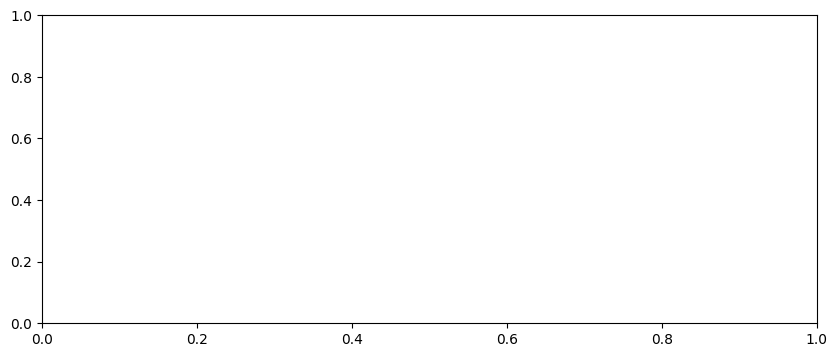

In [150]:
detected = np.array([i for i in range(len(spc_detector.states)) if spc_detector.states[i] == 2])
real = [30000, 45000, 105000]

fig = plt.figure(figsize=(10,4))
plt.bar([0.3, 0.75, 1.2, 1.65, 2.1, 2.55, 3.0], detected-real, width=0.3)
plt.xticks(ticks=[0.3, 0.75, 1.2, 1.65, 2.1, 2.55, 3.0],
           labels=['C1 -> C2', 'C2 -> C3', 'C3 -> C4', 'C4 -> C1', 'C1 -> C2', 'C2 -> C3', 'C3 -> C4'])

plt.ylabel('Number of examples')
plt.title(f'Time difference between real and detected drift (avg = {int(np.mean(detected-real))})')

<a id='fading'></a>
### 4.2 - Exponential smoothing SPC:

Exponential smootinhg the error

#### 4.2.1 - Fading factor = 0.99:

Error after 500 samples = 17.0%
Error after 1000 samples = 14.5%
Error after 1500 samples = 13.6%
Error after 2000 samples = 13.55%
Error after 2500 samples = 13.12%
Error after 3000 samples = 13.27%
Error after 3500 samples = 12.77%
Error after 4000 samples = 12.52%
Error after 4500 samples = 12.73%
Error after 5000 samples = 12.74%
Error after 5500 samples = 12.76%
Error after 6000 samples = 12.72%
Error after 6500 samples = 12.49%
Error after 7000 samples = 12.39%
Error after 7500 samples = 12.36%
Error after 8000 samples = 12.32%
Error after 8500 samples = 12.35%
Error after 9000 samples = 12.39%
Error after 9500 samples = 12.38%
Error after 10000 samples = 12.36%
Error after 10500 samples = 12.45%
Error after 11000 samples = 12.56%
Error after 11500 samples = 12.5%
Error after 12000 samples = 12.51%
Error after 12500 samples = 12.46%
Error after 13000 samples = 12.45%
Error after 13500 samples = 12.37%
Error after 14000 samples = 12.24%
Error after 14500 samples = 12.2%
Error afte

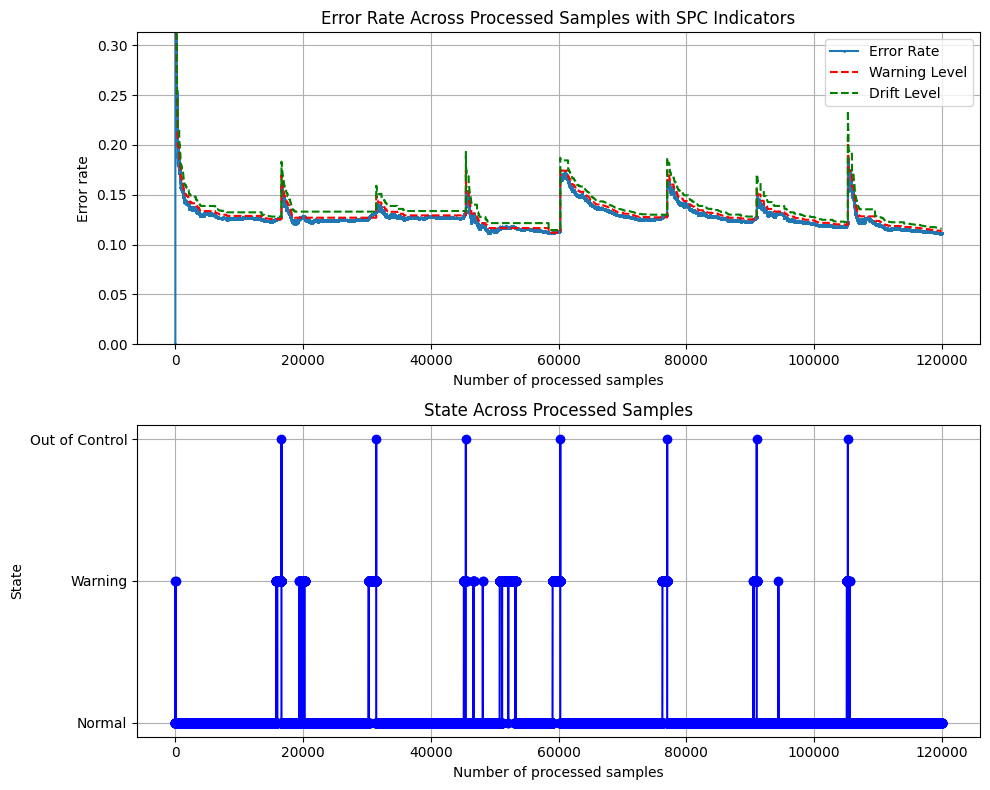

In [17]:
# EXPONENTIAL FACTOR = 0.99
spc_detector = SPCAlgorithm(init_estimator_GaussianNB)

report = 500
warn = -1
retrain = -1
E, N = [0], [0]
baseline, e = [], 0
baseline_model = init_estimator_GaussianNB()

for i in range(data_stream.shape[0]):
    status, y, y_pred = spc_detector.model_control(data_stream, i, exponential=True)
    N.append(N[-1] + 1)
    E.append(E[-1] + (y!=y_pred)+0)

    # baseline
    y_pred = baseline_model.predict_one(data_stream.iloc[i, :-1])
    baseline_model.learn_one(data_stream.iloc[i, :-1], data_stream.iloc[i, -1])
    e += (data_stream.iloc[i, -1] != y_pred)+0
    baseline.append(e/(i+1))

    if (i+1)%report == 0: 
        print(f'Error after {i+1} samples = {np.round(100*E[-1]/N[-1], 2)}%')
        E, N = np.array(E), np.array(N)
        E, N = list(E), list(N)

    if status == 'Warning Level' and warn == -1 and i!=0:
        warn = i
        retrain = -1
        #print(f'Warning after {i+1} samples')
    elif status == 'Out-control' and retrain == -1 and i!=0:
        print(f'Re-train model after {i+1} samples')
        retrain = i
        warn = -1
    else:
        warn = -1
        retrain = -1

# Plotting
spc_detector.process_plot()

In [9]:
real = 15000*np.arange(1, 8)
real

array([ 15000,  30000,  45000,  60000,  75000,  90000, 105000])

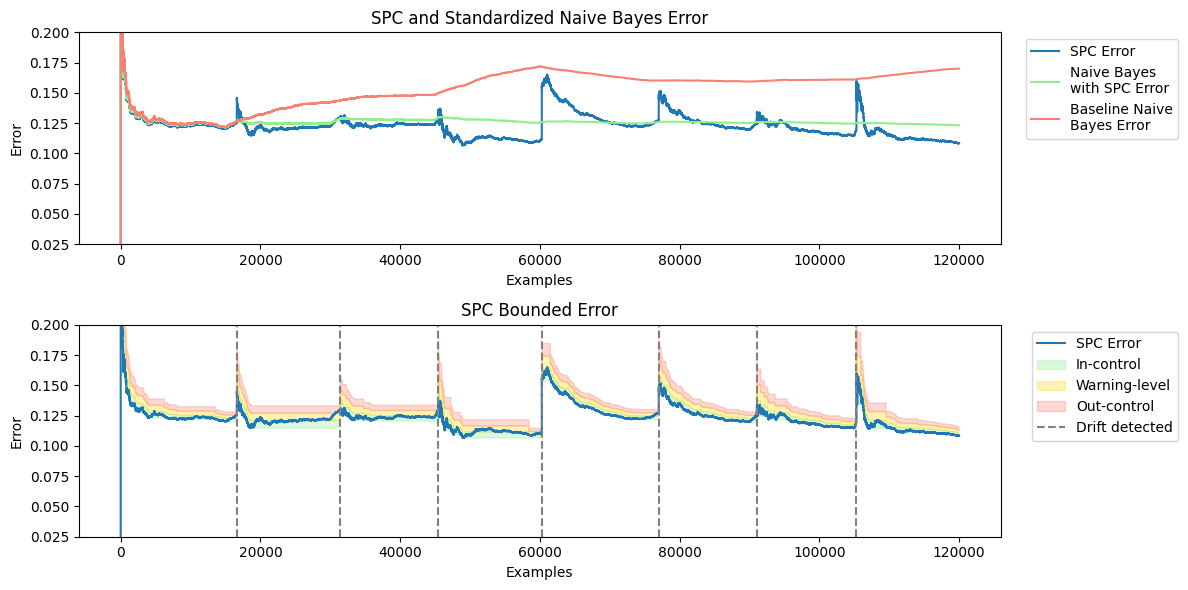

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
ax1.plot(N[1:], np.array(spc_detector.ps), label='SPC Error')
ax1.plot(N[1:], np.array(E[1:])/np.array(N[1:]), color='lightgreen', label='Naive Bayes\nwith SPC Error')
ax1.plot(N[1:], baseline, color='salmon', label='Baseline Naive\nBayes Error')

ax2.plot(N[1:], np.array(spc_detector.ps), label='SPC Error')
ax2.fill_between(N[1:], np.array(spc_detector.Pmins), np.array(spc_detector.Pmins) + np.array(spc_detector.Smins),
                 alpha=0.3, color='lightgreen', label='In-control')
ax2.fill_between(N[1:], np.array(spc_detector.Pmins) + np.array(spc_detector.Smins),
                        np.array(spc_detector.Pmins) + 2*np.array(spc_detector.Smins), alpha=0.3, color='gold', label='Warning-level')
ax2.fill_between(N[1:], np.array(spc_detector.Pmins) + 2*np.array(spc_detector.Smins),
                        np.array(spc_detector.Pmins) + 3*np.array(spc_detector.Smins), alpha=0.3, color='salmon', label='Out-control')
ax2.vlines([i for i in range(len(spc_detector.states)) if spc_detector.states[i] == 2], ymin=0.025, ymax=0.2,
           color='grey', linestyles='dashed', label='Drift detected')
#ax2.vlines(real, ymin=0.025, ymax=0.2, color='grey', linestyles='dashed', label='Real Drift')

ax1.set_ylim(0.025, 0.2)
ax2.set_ylim(0.025, 0.2)
ax1.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
ax2.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
ax1.set_title('SPC and Standardized Naive Bayes Error')
ax2.set_title('SPC Bounded Error')
ax1.set_xlabel('Examples')
ax2.set_xlabel('Examples')
ax1.set_ylabel('Error')
ax2.set_ylabel('Error')
plt.tight_layout()
plt.show()

In [22]:
np.array([i for i in range(len(spc_detector.states)) if spc_detector.states[i] == 2])
# em alguns casos foi mais rapido a detetar o drift - media de tempo diminuiu
# alpha = 0.99, experimentar com 0.85
# [16614, 31303, 46405, 60283, 77016, 91039, 105313] - standard version

array([ 16617,  31453,  45491,  60276,  77016,  91039, 105314])

Text(0.5, 1.0, 'Time difference between real and detected drift (avg = 1029)')

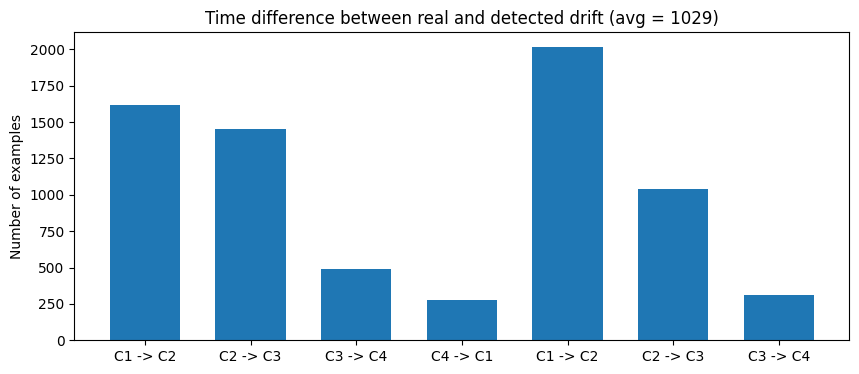

In [23]:
detected = np.array([i for i in range(len(spc_detector.states)) if spc_detector.states[i] == 2])
real = 15000*np.array(np.arange(1,8))

fig = plt.figure(figsize=(10,4))
plt.bar([0.3, 0.75, 1.2, 1.65, 2.1, 2.55, 3.0], detected-real, width=0.3)
plt.xticks(ticks=[0.3, 0.75, 1.2, 1.65, 2.1, 2.55, 3.0],
           labels=['C1 -> C2', 'C2 -> C3', 'C3 -> C4', 'C4 -> C1', 'C1 -> C2', 'C2 -> C3', 'C3 -> C4'])

plt.ylabel('Number of examples')
plt.title(f'Time difference between real and detected drift (avg = {int(np.mean(detected-real))})')

#### 4.2.2 - Fading factor = 0.9:

Error after 500 samples = 18.0%
Error after 1000 samples = 15.1%
Error after 1500 samples = 14.0%
Error after 2000 samples = 13.85%
Error after 2500 samples = 13.36%
Error after 3000 samples = 13.47%
Error after 3500 samples = 12.97%
Error after 4000 samples = 12.7%
Error after 4500 samples = 12.89%
Error after 5000 samples = 12.88%
Error after 5500 samples = 12.89%
Error after 6000 samples = 12.83%
Error after 6500 samples = 12.6%
Error after 7000 samples = 12.49%
Error after 7500 samples = 12.45%
Error after 8000 samples = 12.41%
Error after 8500 samples = 12.44%
Error after 9000 samples = 12.47%
Error after 9500 samples = 12.45%
Error after 10000 samples = 12.43%
Error after 10500 samples = 12.52%
Error after 11000 samples = 12.64%
Error after 11500 samples = 12.57%
Error after 12000 samples = 12.58%
Error after 12500 samples = 12.51%
Error after 13000 samples = 12.5%
Error after 13500 samples = 12.42%
Error after 14000 samples = 12.29%
Error after 14500 samples = 12.25%
Error after

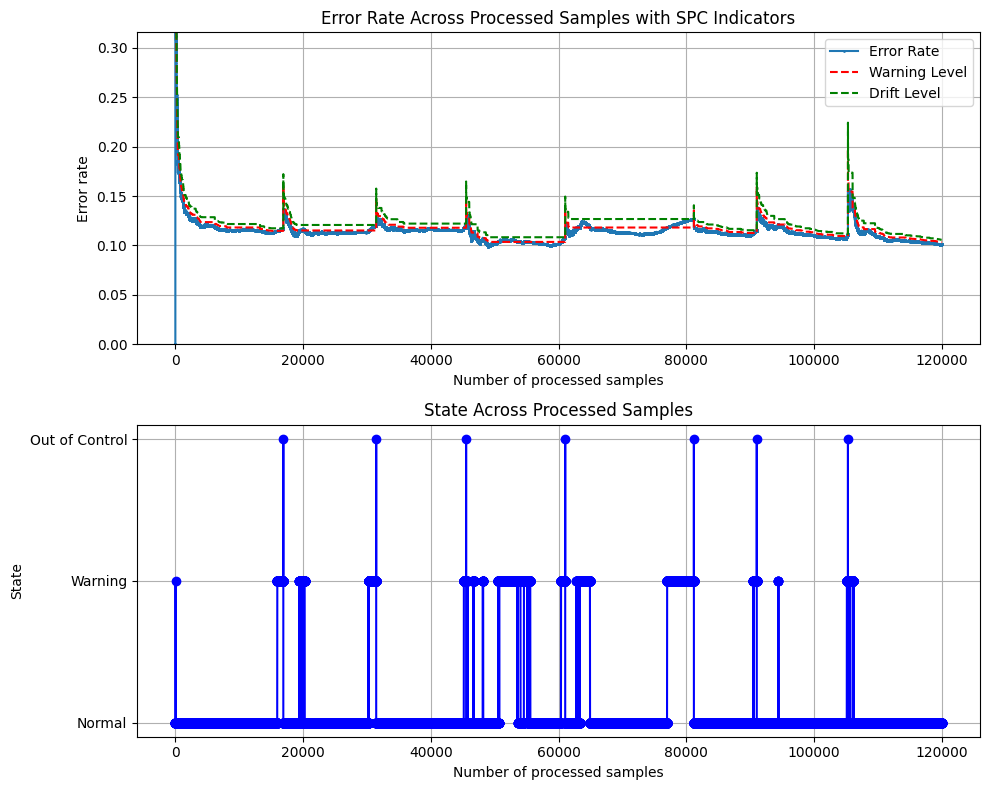

In [25]:
# EXPONENTIAL FACTOR = 0.9
spc_detector = SPCAlgorithm(init_estimator_GaussianNB)

report = 500
warn = -1
retrain = -1
E, N = [0], [0]
baseline, e = [], 0
baseline_model = init_estimator_GaussianNB()

for i in range(data_stream.shape[0]):
    status, y, y_pred = spc_detector.model_control(data_stream, i, exponential=True)
    N.append(N[-1] + 1)
    E.append(E[-1] + (y!=y_pred)+0)

    # baseline
    y_pred = baseline_model.predict_one(data_stream.iloc[i, :-1])
    baseline_model.learn_one(data_stream.iloc[i, :-1], data_stream.iloc[i, -1])
    e += (data_stream.iloc[i, -1] != y_pred)+0
    baseline.append(e/(i+1))

    if (i+1)%report == 0: 
        print(f'Error after {i+1} samples = {np.round(100*E[-1]/N[-1], 2)}%')
        E, N = np.array(E), np.array(N)
        E, N = list(E), list(N)

    if status == 'Warning Level' and warn == -1 and i!=0:
        warn = i
        retrain = -1
        #print(f'Warning after {i+1} samples')
    elif status == 'Out-control' and retrain == -1 and i!=0:
        print(f'Re-train model after {i+1} samples')
        retrain = i
        warn = -1
    else:
        warn = -1
        retrain = -1

# Plotting
spc_detector.process_plot()

In [29]:
np.array([i for i in range(len(spc_detector.states)) if spc_detector.states[i] == 2])
# bastante mais lento a detetar o drift (apenas um caso em que foi ligeiramente mais rápido)
# [16614, 31303, 46405, 60283, 77016, 91039, 105313] - standard version

array([ 16907,  31451,  45530,  61047,  81197,  91044, 105322])

Text(0.5, 1.0, 'Time difference between real and detected drift (avg = 1785)')

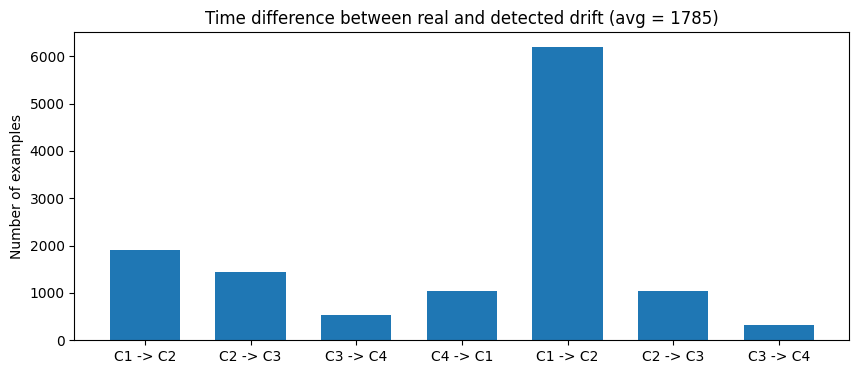

In [30]:
detected = np.array([i for i in range(len(spc_detector.states)) if spc_detector.states[i] == 2])
real = 15000*np.array(np.arange(1,8))

fig = plt.figure(figsize=(10,4))
plt.bar([0.3, 0.75, 1.2, 1.65, 2.1, 2.55, 3.0], detected-real, width=0.3)
plt.xticks(ticks=[0.3, 0.75, 1.2, 1.65, 2.1, 2.55, 3.0],
           labels=['C1 -> C2', 'C2 -> C3', 'C3 -> C4', 'C4 -> C1', 'C1 -> C2', 'C2 -> C3', 'C3 -> C4'])

plt.ylabel('Number of examples')
plt.title(f'Time difference between real and detected drift (avg = {int(np.mean(detected-real))})')

<a id='window'></a>
### 4.3 - Sliding window strategy to update the error:

Define sliding window size carefully.